# Opis notatnika

Jest to docelowy notatnik, służący przeprowadzaniu eksperymentów rozwiązania. Planowane są następujące porówania:
- SA vs HC
- SA vs RS
- Wpływ wykorzystywanych pokemonów na wyniki
- Wpływ pokemonów legendarnych na wyniki
- Wpływ ilość zmienianych pokemonów w drużynie po przegranej na wyniki
- Ewaluacja nalepszych druzyń (znalezionych przez nasz algorytm)

### Importy

In [7]:
import sys
from pathlib import Path
import pandas as pd

SRC = (Path("..")).resolve()
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))


In [8]:
from classes.pokemon_team import PokemonTeam
from visualization.utils import summarize
from data.data import get_pokemons
from report.reports import PdfReport
from experiments.sa_experiments import run_multiple_runs, compare_to_hill_climb, compare_to_random_search
from visualization.plots import visualize_opponents_typing_distribution, visualize_opponents_stat_sums_violin
from constants import REPORT_DIR

In [9]:
from solvers import SimulatedAnnealingPokemonSolver
from solvers import HillClimbingPokemonSolver
from solvers import RandomSearchPokemonSolver

### Parametry startowe

In [10]:
pokemons = get_pokemons()
all_pokemons = get_pokemons(include_only_final_evolutions=False)
all_pokemons_and_legendaries = get_pokemons(include_legendary=True, include_only_final_evolutions=False)

In [11]:
print("Ilość dostępnych pokemonów bazowo:", len(pokemons))
print("Ilość dostępnych pokemonów (wszystkie ewolucje):", len(all_pokemons))
print("Ilość dostępnych pokemonów (wszystkie ewolucje + legendarne):", len(all_pokemons_and_legendaries))

Ilość dostępnych pokemonów bazowo: 359
Ilość dostępnych pokemonów (wszystkie ewolucje): 731
Ilość dostępnych pokemonów (wszystkie ewolucje + legendarne): 801


#### Wielkość przestrzeni przeszukiwań

- Lista oponentów będzie składała się z 50 losowych drużyn, w celu przeprowadzenia szybszych eksperymentów. 
- Następnie najlepsze z drużyn zostaną wziętę pod uwagę w porównaniu i zostaną przetestowane na większym zbiorze, w celu weryfikacji ich skuteczności.
- Każda solver, będzie działał na takim samym budżecie równym 300 iteracją (w celu szybkiego szukania drużyn)
- Z wstępnych eksperymentów wyszło, że duża temperatura negatywnie wpływała na solver SA, więc zaczynać będziemy z wartością 0.3 i zmniejszać będziemy ją o 0.80

In [12]:
OPPONENTS_LIMIT = 50
BUDGET = 300
INITIAL_TEMPERATURE = 0.3
COOLING = 0.8

In [13]:
sa_solver = SimulatedAnnealingPokemonSolver(
    initial_temperature=INITIAL_TEMPERATURE,
    min_temperature=1e-3,
    alpha=COOLING,
    iters_per_temp=30,
    max_evaluations=BUDGET,
    neighbor_replacements=1,
    opponents_limit=OPPONENTS_LIMIT,
    unique_types=True,
    patience=50,
    restarts=0,
    )

hc_solver = HillClimbingPokemonSolver(
    max_evaluations=BUDGET,
    neighbors_per_step=30,
    neighbor_replacements=1,
    opponents_limit=OPPONENTS_LIMIT,
    unique_types=True,
    patience=50,
    restarts=0)

rs_solver = RandomSearchPokemonSolver(trials=BUDGET, opponents_limit=OPPONENTS_LIMIT, unique_types=True)

### Opponents (50 drużyn)

In [14]:
pokemons = get_pokemons()
opponents = PokemonTeam.generate_unique_teams(
    pokemons,
    opponents_limit=OPPONENTS_LIMIT,
    max_attempts=OPPONENTS_LIMIT * 3,
    team_size=6,
    unique_types=True,
)

# Porównanie SA vs HC (10 runów)

C:\Users\barte\OneDrive\Pulpit\POP - projekt\pop-project\src\visualization\plots.py:53: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Comparing SA solver to Hill Climbing solver...
 Run 1/10...
  SA fitness: 0.32333839150227617, HC fitness: 0.5096759259259259
  SA team: ['Plusle', 'Excadrill', 'Arcanine', 'Snorlax', 'Umbreon', 'Hariyama']
  HC team: ['Tyranitar', 'Chesnaught', 'Vaporeon', 'Wobbuffet', 'Aromatisse', 'Blissey']
 Run 2/10...
  SA fitness: 0.20454545454545456, HC fitness: 0.3851917404129794
  SA team: ['Gardevoir', 'Lucario', 'Garchomp', 'Garbodor', 'Jellicent', 'Vivillon']
  HC team: ['Hydreigon', 'Heracross', 'Aurorus', 'Hippowdon', 'Lickilicky', 'Alomomola']
 Run 3/10...
  SA fitness: 0.395584082156611, HC fitness: 0.49302895322939877
  SA team: ['Skuntank', 'Blissey', 'Eelektross', 'Xatu', 'Wailord', 'Aromatisse']
  HC team: ['Blissey', 'Vaporeon', 'Luxray', 'Throh', 'Wobbuffet', 'Gogoat']
 Run 4/10...
  SA fitness: 0.23795731707317075, HC fitness: 0.4141469816272966
  SA team: ['Wailord', 'Volcarona', 'Avalugg', 'Goodra', 'Swalot', 'Musharna']
  HC team: ['Excadrill', 'Aromatisse', 'Slaking', 'Wobbu

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\barte\\OneDrive\\Pulpit\\POP - projekt\\pop-project\\src\\data\\report\\sa_vs_hc_last_evolutions.pdf'

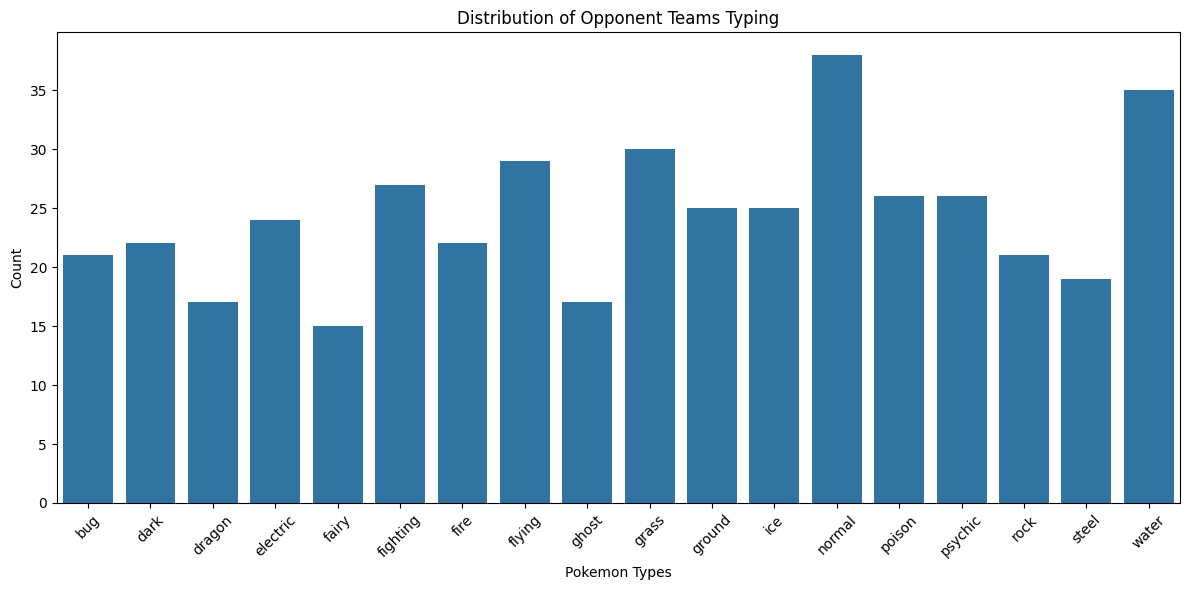

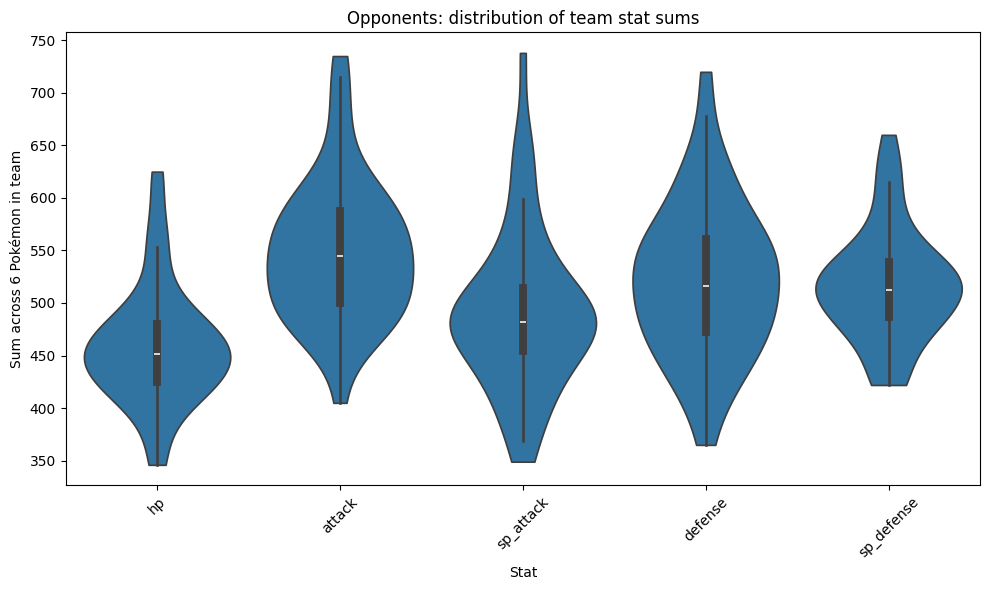

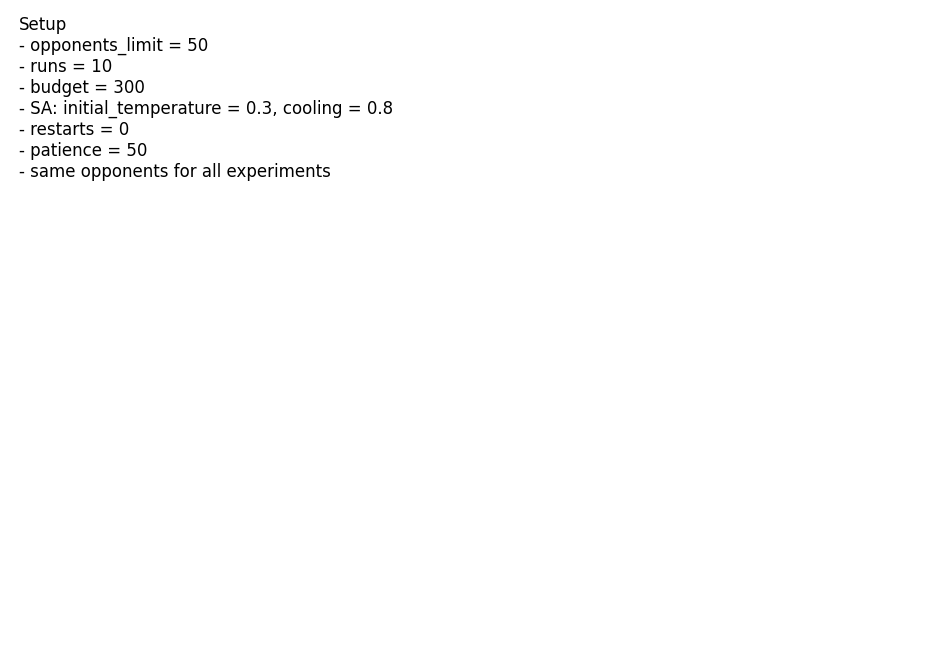

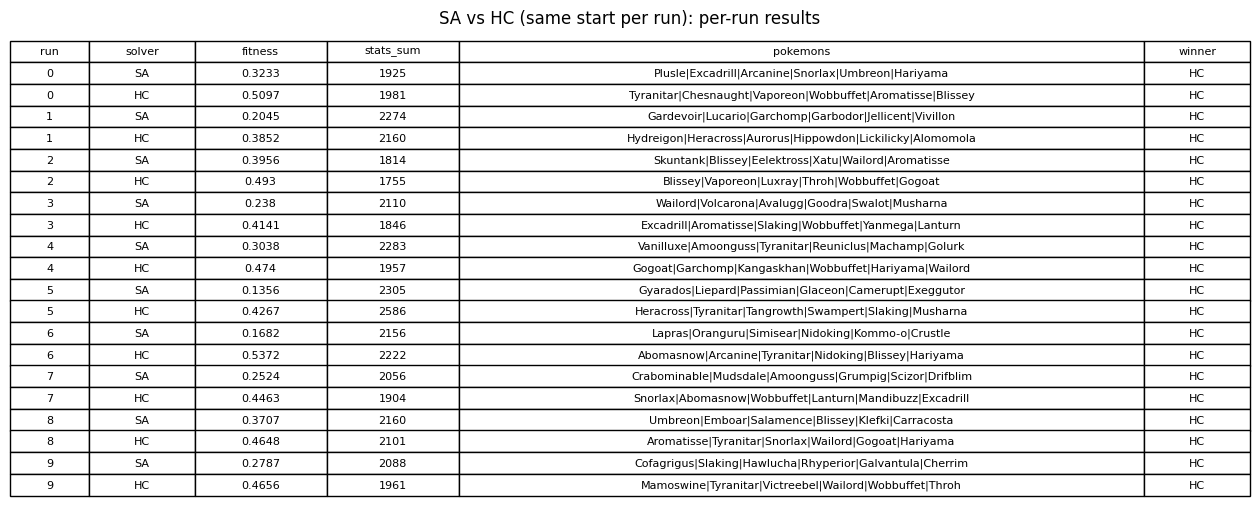

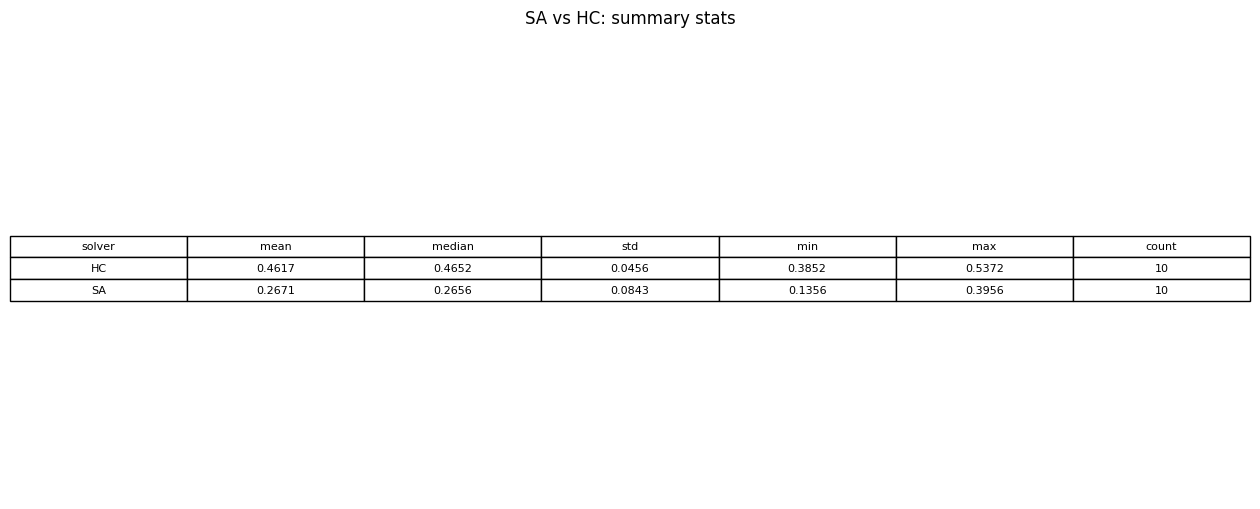

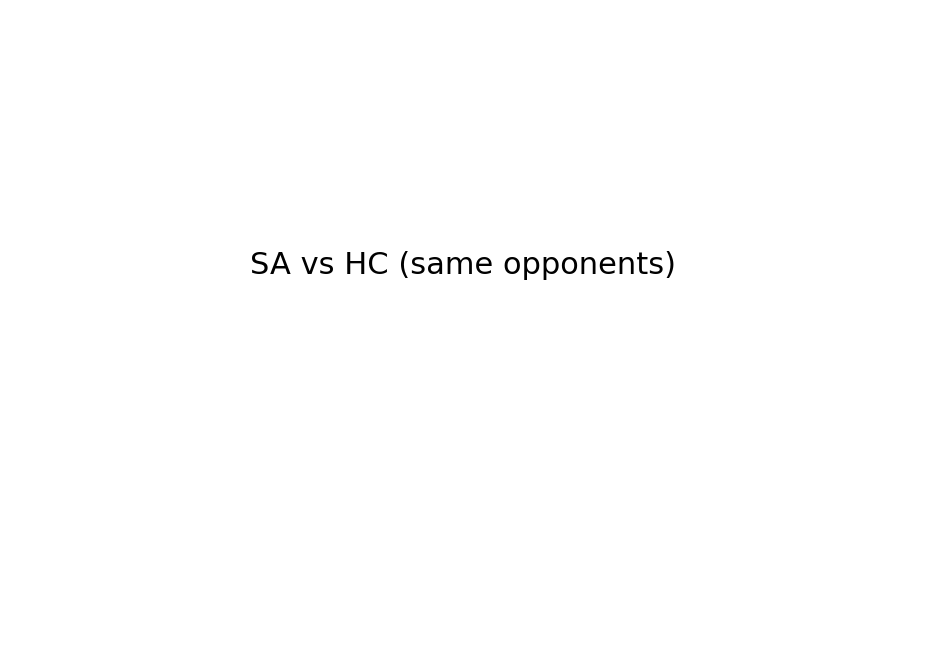

In [15]:
opponents_typings = visualize_opponents_typing_distribution(opponents)
opponents_stats = visualize_opponents_stat_sums_violin(opponents)

df_sa_vs_hc = compare_to_hill_climb(pokemons, sa_solver, hc_solver, opponents=opponents, runs=10)

sum_sa_hc = summarize(df_sa_vs_hc)

report = PdfReport(str(REPORT_DIR / "sa_vs_hc_last_evolutions.pdf"), title="SA vs HC (same opponents)")

report.add_text(
    f"""Setup
- opponents_limit = {len(opponents)}
- runs = 10
- budget = {BUDGET}
- SA: initial_temperature = {INITIAL_TEMPERATURE}, cooling = {COOLING}
- restarts = 0
- patience = 50
- same opponents for all experiments
"""
)

report.add_figure(opponents_typings)
report.add_figure(opponents_stats)


report.add_dataframe(df_sa_vs_hc, "SA vs HC (same start per run): per-run results")
report.add_dataframe(sum_sa_hc, "SA vs HC: summary stats")


report.write()
print(f"Saved: {REPORT_DIR / 'report_sa_experiments.pdf'}")

# Porównanie SA vs RS

# Uwzględnienie pełnej listy pokemonów (tylko SA)

# Uwzględnienie pokemonów legendarnych (tylko SA)

# Wpływ ilości zmienianych pokemonów po przegranej (tylko SA)

# Turniej pokemonów